In [1]:
# pip install shapely

In [2]:
import os; import pathlib as pl ; import flopy ; import git ; import matplotlib.pyplot as plt ; import pandas as pd 
import numpy as np ; from flopy.plot.styles import styles  ; from modflow_devtools.misc import get_env, timed ; from pathlib import Path
import matplotlib as mpl; import csv; from shapely.geometry import Polygon; from flopy.utils.gridintersect import GridIntersect

In [3]:
sim_name = "ex-gwf-advtidal" ; output_folder = Path("./04_advtidal") ; output_folder.mkdir(exist_ok=True) 
parameter_units = {"recharge": "$ft/s$"}  ; length_units = "feet"  ; time_units = "seconds" 
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-advtidal'
data_FP1=os.path.join(path,"tides.csv")      ; data_FP2=os.path.join(path,"wellrates.csv")   
data_FP3=os.path.join(path,"riverstage.csv") ; data_FP4=os.path.join(path,"recharge1.csv")
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name # "toth"

In [4]:
length_units = "meters"       ;  nper = 4 ;  nlay = 3 ;  ncol = 10 ;  nrow = 15 ;  delr = 500 ;  delc = 500 ;  top = 50 
time_units = "days"           ;  strt = 50 ;  icelltype_str = "1,0,0" ;  k11_str = "5.0,0.1,4.0" ;  k33_str = "0.5,5.0e-3,0.1"   
botm_str = "5.0,-10.0,-100.0" ; ss = 0.000001 ;  sy = 0.2 ;  nouter = 50 ;  ninner = 100 ;  hclose = 0.000000001 ;  rclose = 0.000001   

perlen = [1.0, 10.0, 10.0, 10.0]  ; nstp = [1, 120, 120, 120] ; tsmult = [1.0, 1.0, 1.0, 1.0] ; tdis_ds = list(zip(perlen, nstp, tsmult))

recharge_zone_1 = Polygon(shell=[(0, 0), (3000, 0), (3000, 5500), (1000, 7500), (0, 7500), (0, 0)])
recharge_zone_2 = Polygon(shell=[(1000, 7500), (3000, 5500), (5000, 7500), (1000, 7500)])
recharge_zone_3 = Polygon(shell=[(3000, 0), (5000, 0), (5000, 7500), (3000, 5500), (3000, 0)])

nseg = 3 ;  etsurf = 50 ;  etrate = 0.0004 ;  depth = 10 ;  pxdp = [0.2,0.5] ;  petm = [0.3,0.1] ;  

botm = [float(value) for value in botm_str.split(",")]  ; k11 = [float(value) for value in k11_str.split(",")]
k33 = [float(value) for value in k33_str.split(",")]    ; icelltype = [int(value) for value in icelltype_str.split(",")]

In [5]:
def get_timeseries(fname, names, interpolation, filename=None):
    tsdata = []
    for row in np.genfromtxt(fname, delimiter=",", comments="#"):
        tsdata.append(tuple(row))
    tsdict = {"timeseries": tsdata,"time_series_namerecord": names,"interpolation_methodrecord": interpolation}
    if filename is not None:
        tsdict["filename"] = filename
    return tsdict

In [6]:
sim_ws = os.path.join(workspace, sim_name)
sim = flopy.mf6.MFSimulation(sim_name=sim_name,sim_ws=sim_ws,exe_name=exe_name,verbosity_level=0,)
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
flopy.mf6.ModflowIms(sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
flopy.mf6.ModflowGwfnpf(gwf,cvoptions="perched",perched=True,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True)
flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfsto(gwf,iconvert=1,ss=1.0e-6,sy=sy,steady_state={0: True},transient={1: True},)
ghb_spd = []  
ghb_spd += [[1, i, 9, "tides", 15.0, "ESTUARY-L2"] for i in range(nrow)]
ghb_spd += [[2, i, 9, "tides", 1500.0, "ESTUARY-L3"] for i in range(nrow)] ; ghb_spd = {0: ghb_spd} ; 

In [7]:
tsdict = get_timeseries(data_FP1, "tides", "linear")     ; ghbobs_dict = {}
ghbobs_dict[f"{sim_name}.ghb.obs.csv"] = [("ghb_2_6_10", "ghb", (1, 5, 9)),("ghb_3_6_10", "ghb", (2, 5, 9)),
                                          ("estuary2", "ghb", "ESTUARY-L2"),("estuary3", "ghb" , "ESTUARY-L3"),]
flopy.mf6.ModflowGwfghb(gwf,stress_period_data=ghb_spd,boundnames=True     ,timeseries=tsdict  ,observations=ghbobs_dict,     pname="GHB-TIDAL") ; 

In [8]:
wel_spd = {}
wel_spd[1] = [[0, 11, 2, -50, ""],[2, 4, 7, "well_1_rate", "well_1"],[2, 3, 2, "well_2_rate", "well_2"]]
wel_spd[2] = [[2, 3, 2, "well_2_rate", "well_2"],[2, 4, 7, "well_1_rate", "well_1"]]
wel_spd[3] = [[2, 4, 7, "well_1_rate", "well_1"],[2, 3, 2, "well_2_rate", "well_2"],[0, 11, 2, -10, ""],[0, 2, 4, -20, ""],[0, 13, 5, -40, ""]]
tsdict = get_timeseries(data_FP2, ["well_1_rate", "well_2_rate", "well_6_rate"], 3 * ["stepwise"])
flopy.mf6.ModflowGwfwel(gwf,stress_period_data=wel_spd,boundnames=True,timeseries=tsdict,pname="WEL")

rivrow = [2, 3, 4, 4, 5, 5, 5, 4, 4, 4, 9, 8, 7, 6, 6, 5, 5, 6, 6, 6] ; rivcol = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rivstg = 10 * ["river_stage_1"] + 10 * ["river_stage_2"] ; rivcnd = 2 * [1000 + f + 1 for f in range(10)]
rivrbt = list(np.linspace(35.9, 35.0, 10)) + list(np.linspace(36.9, 36.0, 10))  ; rivlay = 20 * [0]
rivbnd = (5 * [""]+ ["riv1_c6", "riv1_c7"]+ 3 * [""]+ 3 * ["riv2_upper"]+ 2 * [""]+ ["riv2_c6", "riv2_c7"]+ 3 * [""])
riv_spd = list(zip(rivlay, rivrow, rivcol, rivstg, rivcnd, rivrbt, rivbnd))
    
tsdict = get_timeseries(data_FP3,["river_stage_1", "river_stage_2"],["linear", "stepwise"])
flopy.mf6.ModflowGwfriv(gwf     , stress_period_data=riv_spd       ,boundnames=True           ,timeseries=tsdict,pname="RIV") ; 

In [9]:
for ipak, p in enumerate([recharge_zone_1, recharge_zone_2, recharge_zone_3]) :
    ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)  ; result = ix.intersect(p)       ; rch_spd = []
    for i in range(result.shape[0]):
        rch_spd.append([0,*result["cellids"][i],f"rch_{ipak + 1}",result["areas"][i] / delr / delc])

    fname = f"recharge{ipak + 1}.csv"  
    tsdict = get_timeseries(data_FP4,[f"rch_{ipak + 1}"],["stepwise"],filename=f"{sim_name}.rch{ipak + 1}.ts")
    
    flopy.mf6.ModflowGwfrch(gwf,stress_period_data=rch_spd,boundnames=True,     timeseries=tsdict    ,fixed_cell=True,print_input=True,
                            print_flows=True,save_flows=True,auxiliary=["MULTIPLIER"],auxmultname="MULTIPLIER",
                            pname=f"RCH-ZONE_{ipak + 1}",filename=f"{sim_name}.rch{ipak + 1}")

In [10]:
row, col = np.where(np.zeros((nrow, ncol)) == 0)
cellids = list(zip(nrow * ncol * [0], row, col))
evt_spd = [[k, i, j, etsurf, etrate, depth, *pxdp, *petm] for k, i, j in cellids]
flopy.mf6.ModflowGwfevt(gwf, nseg=nseg, stress_period_data=evt_spd, pname="EVT")

head_filerecord = f"{sim_name}.hds"
budget_filerecord = f"{sim_name}.cbc"
flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])

obsdict = {}
obslist = [["h1_13_8", "head", (2, 12, 7)]]
obsdict[f"{sim_name}.obs.head.csv"] = obslist
obslist = [["icf1", "flow-ja-face", (0, 4, 5), (0, 5, 5)]]
obsdict[f"{sim_name}.obs.flow.csv"] = obslist
obs = flopy.mf6.ModflowUtlobs(gwf, print_input=False, continuous=obsdict)

sim.write_simulation(silent=False)  ; sim.run_simulation(silent=False)  # False True

FloPy is using the following executable to run the model: ..\..\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Oct 27 2021 07:53:31 with IFORT compiler (ver. 20.21.1)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the software.

 

(True, [])

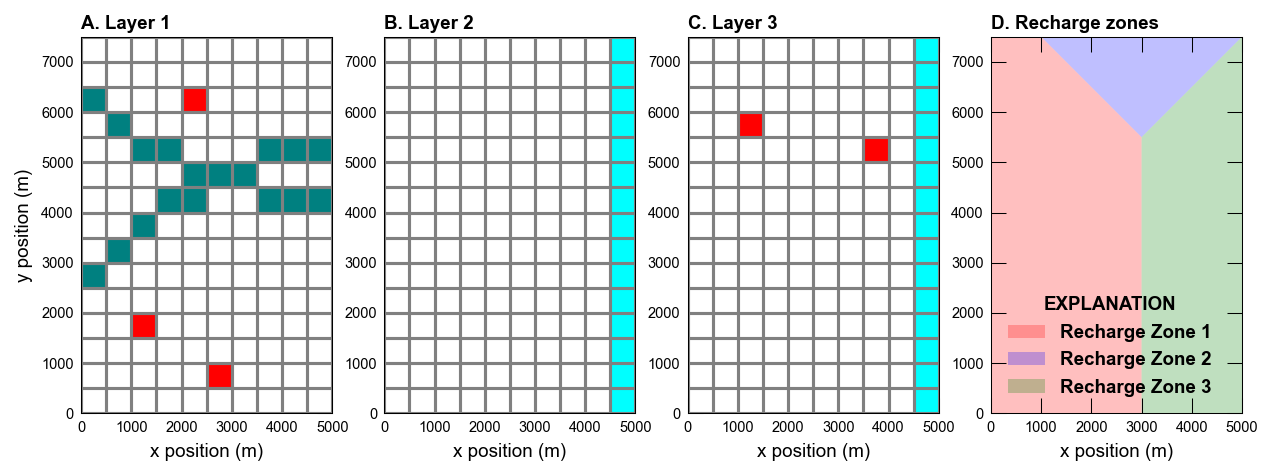

In [11]:
with styles.USGSMap():
    gwf = sim.get_model(sim_name)

    fig = plt.figure(figsize=(10, 15),dpi=150)

    ax = fig.add_subplot(4, 4, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
    pmv.plot_grid()
    pmv.plot_bc(name="WEL", kper=3)
    pmv.plot_bc(name="RIV")
    title = "Layer 1"
    letter = chr(ord("@") + 1)
    styles.heading(letter=letter, heading=title, ax=ax)
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")

    ax = fig.add_subplot(4, 4, 2, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=1)
    pmv.plot_grid()
    pmv.plot_bc(name="GHB")
    title = "Layer 2"
    letter = chr(ord("@") + 2)
    styles.heading(letter=letter, heading=title, ax=ax)
    ax.set_xlabel("x position (m)")


    ax = fig.add_subplot(4, 4, 3, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=2)
    pmv.plot_grid()
    pmv.plot_bc(name="GHB")
    pmv.plot_bc(ftype="WEL", kper=3)
    title = "Layer 3"
    letter = chr(ord("@") + 3)
    styles.heading(letter=letter, heading=title, ax=ax)
    ax.set_xlabel("x position (m)")


    ax = fig.add_subplot(4, 4, 4, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
    pmv.plot_grid(linewidth=0)
    for ip, (p, fc) in enumerate([(recharge_zone_1, "r"), (recharge_zone_2, "b"), (recharge_zone_3, "g")]):
        xs, ys = p.exterior.xy
        ax.fill(xs, ys, alpha=0.25, fc=fc, ec="none", label=f"Recharge Zone {ip + 1}")
    ax.set_xlabel("x position (m)")
    styles.graph_legend(ax)
    title = "Recharge zones"
    letter = chr(ord("@") + 4)
    styles.heading(letter=letter, heading=title, ax=ax); plt.show() ; fig.savefig(output_folder/'04_advtidal')

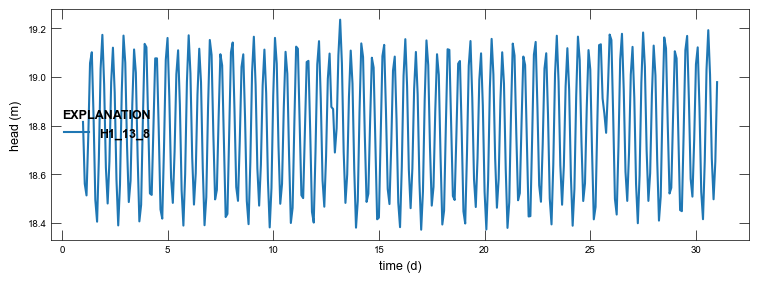

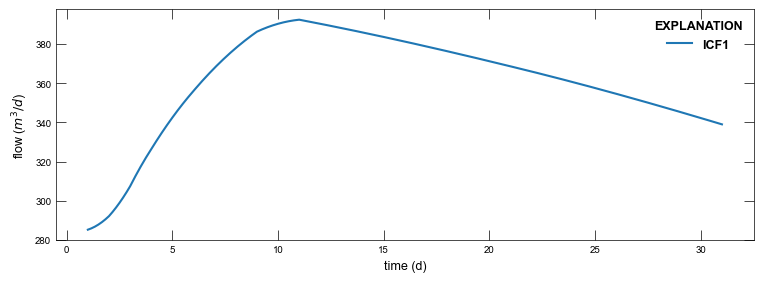

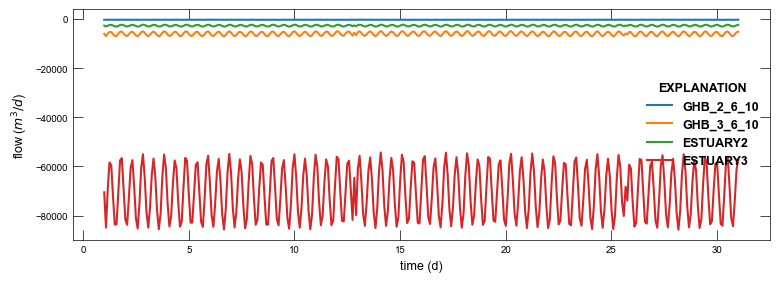

In [13]:
with styles.USGSMap():
    gwf = sim.get_model(sim_name) ; obsnames = gwf.obs[1].output.obs_names
    obs_list = [  gwf.obs[1].output.obs(f=obsnames[0])   ,gwf.obs[1].output.obs(f=obsnames[1])   ,gwf.ghb.output.obs()  ]
    
    ylabel = ("head (m)", "flow ($m^3/d$)", "flow ($m^3/d$)") ; obs_fig = ("obs-head", "obs-flow", "ghb-obs")
    
    for iplot, obstype in enumerate(obs_list):
        fig = plt.figure(figsize=(9, 3)) ; ax = fig.add_subplot() ; tsdata = obstype.data
        
        for name in tsdata.dtype.names[1:]:
            ax.plot(tsdata["totim"], tsdata[name], label=name)
        ax.set_xlabel("time (d)") ; ax.set_ylabel(ylabel[iplot]) ; styles.graph_legend(ax) ; plt.show() ; fig.savefig(output_folder/'04_advtidal')